In [ ]:
import networkx as nx
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict
from scipy.stats import mode
from networkx.algorithms.community import modularity
import time
import requests
def load_football():
    """Load American College Football network"""

    url = "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/football.gml"
    response = requests.get(url)
    """Load Dolphins social network"""
   # G = nx.read_gml('dolphins.gml', label='id')
    with open("football.gml", "wb") as f:
        f.write(response.content)
   # G = nx.read_gml('/content/football.gml')
    G = nx.read_gml('football.gml', label='id')
    true_labels = np.array([int(G.nodes[n]['gt']) for n in G.nodes])
   # mapping = {node: int(node) for node in G.nodes}
# Apply the mapping to update the nodes' labels
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels
def load_dolphins():
    url = "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/dolphins.gml"
    response = requests.get(url)
    """Load Dolphins social network"""
   # G = nx.read_gml('dolphins.gml', label='id')
    with open("dolphins.gml", "wb") as f:
        f.write(response.content)
    G = nx.read_gml('dolphins.gml', label='id')
    true_labels = np.array([int(G.nodes[n]['gt'])- 1 for n in G.nodes])
   # mapping = {node: int(node) for node in G.nodes}
# Apply the mapping to update the nodes' labels
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels
# Load Karate Club dataset
# G = nx.karate_club_graph()
# true_labels = np.array([0 if G.nodes[n]['club'] == 'Mr. Hi' else 1 for n in G.nodes])
# G, true_labels = create_clique_graph()
G, true_labels=load_football()
# G, true_labels=load_dolphins()

# Compute centrality with normalization
def compute_centrality(graph):
    centrality = nx.degree_centrality(graph)
    max_cent = max(centrality.values())
    # print('max cen',max(centrality.values()))
    # print('min cen',min(centrality.values()))

    return centrality#{n: c/max_cent for n, c in centrality.items()}

centrality = compute_centrality(G)

# Enhanced Jaccard similarity with threshold
def compute_similarity(graph, threshold=0.001):
    similarities = defaultdict(dict)
    for u in graph.nodes:
        neighbors_u = set(graph.neighbors(u))
        for v in graph.neighbors(u):
            if v not in similarities[u]:
                neighbors_v = set(graph.neighbors(v))
                intersection = len(neighbors_u & neighbors_v)
                union = len(neighbors_u | neighbors_v)
                jaccard = intersection/union if union != 0 else 0
                #if jaccard > threshold:
                similarities[u][v] = jaccard#**2#**2#**jaccard#*10 #if jaccard > threshold else 0
              #  print(similarities[u][v])
    return similarities

similarities = compute_similarity(G, threshold=2)

# Revised LPA with stronger cohesion
def enhanced_lpa(graph, centrality, similarities, max_iter=50):
    labels = {n: n for n in graph.nodes}
    converged = False
    iter_count = 0

    while not converged and iter_count < max_iter:
        nodes_sorted = sorted(graph.nodes, key=lambda x: (-centrality[x], x))
        # print(nodes_sorted)
        new_labels = labels.copy()
        changed = 0
        community_sizes = defaultdict(int)
        for n in graph.nodes:
            community_sizes[labels[n]] += 1

        for node in nodes_sorted:
            neighbors = list(graph.neighbors(node))
            if not neighbors:
                continue

            label_weights = defaultdict(float)
            for v in neighbors:
                l = labels[v]
                weight =similarities[node][v]*(centrality[v]**0.5)*(community_sizes[l])
                #*centrality[v] (community_sizes[l])*
                #weight =np.log(similarities[node].get(v,0)*1/(1+centrality[v])*community_sizes.get(l, 1)+1)#**0.5 #*centrality[v] (community_sizes[l])*

                #weight =(np.log(similarities[node].get(v,0)*1/np.sqrt(centrality[v])*community_sizes.get(l, 1)+1))#**0.5 #*centrality[v] (community_sizes[l])*
 # print(np.sqrt(community_sizes.get(l, 1)+1),np.sqrt(community_sizes.get(l, 1)))
              #  print(similarities[node].get(v,0),' : ',(centrality[v]))

                #weight =(np.maximum(np.log(similarities[node].get(v,0)*centrality[v]*community_sizes[l]+1),0)) #*centrality[v] (community_sizes[l])*
               # weight = similarities[node].get(v,0)*(np.max(np.log((community_sizes[l]+1)),0))*centrality[v] #*centrality[v]

                label_weights[l] += weight #* community_sizes[l]
             #   print("the weight ",weight,'simi ',similarities[node].get(v,0),"log ",np.log(community_sizes[l]*centrality[v]))
                #print(node ,': ',v,'-', similarities[node][v],' # ',centrality[v],' total', centrality[v]* ( similarities[node].get(v,0)),'com',community_sizes[l])

            if label_weights:
                max_weight = max(label_weights.values())
                candidates = [l for l, w in label_weights.items() if w == max_weight]

                current_label = new_labels[node]
                if current_label not in candidates:
                    cent_scores = {l: max(centrality[n] for n in graph.nodes if labels[n]==l) for l in candidates}
                    new_label = max(cent_scores, key=cent_scores.get)
                    new_labels[node] = new_label
                    changed += 1

        if changed == 0:
            converged = True
        else:
            labels = new_labels
            iter_count += 1

    return np.array([labels[n] for n in graph.nodes])

# Final cluster merging function
def merge_clusters(y_pred, true_labels):
    unique_pred = np.unique(y_pred)
    cluster_to_label = {}

    for cluster in unique_pred:
        mask = (y_pred == cluster)
        mode_result = mode(true_labels[mask])
        true_label = np.atleast_1d(mode_result.mode)[0]  # Critical fix
        cluster_to_label[cluster] = true_label

    # Enforce binary communities
    if len(cluster_to_label) > 2:
        majority_label = np.atleast_1d(mode(true_labels).mode)[0]
        cluster_to_label = {cluster: majority_label for cluster in unique_pred}

    return np.array([cluster_to_label[l] for l in y_pred])
def align_labels(y_true, y_pred):
    label_map = {}
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        mode_result = mode(y_true[mask], keepdims=True)
        true_label = np.atleast_1d(mode_result.mode)[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)

start_time = time.time()
# Execute and evaluate
pred_labels = enhanced_lpa(G, centrality, similarities)
execution_time = time.time() - start_time
aligned_pred = align_labels( true_labels,pred_labels)
unique_labels = np.unique(pred_labels)

predicted_communities = [set(np.where(pred_labels == label)[0]) for label in unique_labels]

# for i, community in enumerate(predicted_communities):
#     for node in community:
#         pred_labels[node] = i
# Calculate metrics
nmi = normalized_mutual_info_score(true_labels, pred_labels)
ari = adjusted_rand_score(true_labels, pred_labels)
f1 = f1_score(true_labels, aligned_pred ,average='micro' )
acc = accuracy_score(true_labels, pred_labels)
# Convert the predicted labels into community sets

print('true_labels',true_labels)
print('pred_labels',pred_labels)
print('aligned_pred',aligned_pred)
#print(predicted_labels_for_nmi)

modularity_score = modularity(G, predicted_communities)
print(f"True communities: {len(np.unique(true_labels))}")
print(f"Predicted communities: {len(np.unique(pred_labels))}")
print(f"Predicted communities Align: {len(np.unique(aligned_pred))}")

print(f'Modularity: {modularity_score}')

print(f"\nNMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")
print(f"F1: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Execution time: {execution_time} seconds")

true_labels [ 7  0  2  3  7  3  2  8  8  7  3 10  6  2  6  2  7  9  6  1  9  8  8  7
 10  0  6  9 11  1  1  6  2  0  6  1  5  0  6  2  3  7  5  6  4  0 11  2
  4 11 10  8  3 11  6  1  9  4 11 10  2  6  9 10  2  9  4 11  8 10  9  6
  3 11  3  4  9  8  8  1  5  3  5 11  3  6  4  9 11  0  5  4  4  7  1  9
  9 10  3  6  2  1  3  0  7  0  2  3  8  0  4  8  4  9 11]
pred_labels [ 41  33  32 107  41 107  32  22  22  41 107  28  54  32  54  32  41  95
  54  94  95  22  22  41  28  33  54  95  28  94  94  54  32  33  54  94
  54  33  54  32 107  41  54  54  57  33  49  32  57  49  28  22 107  49
  54  94  95  57  95  95  32  54  95  95  32  95  57  49  22  28  95  54
 107  49 107  57  95  22  22  94  94 107  94  49 107  54  57  95  49  33
  28  57  57  41  94  95  95  95 107  54  32  94 107  33  41  33  32 107
  22  33  49  22  57  95  49]
aligned_pred [ 7  0  2  3  7  3  2  8  8  7  3 10  6  2  6  2  7  9  6  1  9  8  8  7
 10  0  6  9 10  1  1  6  2  0  6  1  6  0  6  2  3  7  6  6  4  0 11  

In [ ]:
import networkx as nx
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict
from scipy.stats import mode
from networkx.algorithms.community import modularity
import time
import requests
import math
from collections import defaultdict
from scipy.sparse import csr_matrix, diags

from scipy.linalg import pinv

def load_football():
    """Load American College Football network"""

    url = "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/football.gml"
    response = requests.get(url)
    """Load Dolphins social network"""
   # G = nx.read_gml('dolphins.gml', label='id')
    with open("football.gml", "wb") as f:
        f.write(response.content)
   # G = nx.read_gml('/content/football.gml')
    G = nx.read_gml('football.gml', label='id')
    true_labels = np.array([int(G.nodes[n]['gt']) for n in G.nodes])
   # mapping = {node: int(node) for node in G.nodes}
# Apply the mapping to update the nodes' labels
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels
def load_dolphins():
    url = "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/dolphins.gml"
    response = requests.get(url)
    """Load Dolphins social network"""
   # G = nx.read_gml('dolphins.gml', label='id')
    with open("dolphins.gml", "wb") as f:
        f.write(response.content)
    G = nx.read_gml('dolphins.gml', label='id')
    true_labels = np.array([int(G.nodes[n]['gt'])- 1 for n in G.nodes])
   # mapping = {node: int(node) for node in G.nodes}
# Apply the mapping to update the nodes' labels
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels
# Load Karate Club dataset
# G = nx.karate_club_graph()
# true_labels = np.array([0 if G.nodes[n]['club'] == 'Mr. Hi' else 1 for n in G.nodes])
# G, true_labels = create_clique_graph()
G, true_labels=load_football()
# G, true_labels=load_dolphins()

# Compute centrality with normalization
def compute_centrality(graph):
    centrality = nx.degree_centrality(graph)
    max_cent = max(centrality.values())
    # print('max cen',max(centrality.values()))
    # print('min cen',min(centrality.values()))

    return {n: c/max_cent for n, c in centrality.items()}

centrality = compute_centrality(G)


def compute_similarity1(graph):
    similarities = defaultdict(dict)
    nb=0
    for u in graph.nodes:
        neighbors_u = set(graph.neighbors(u))
        for v in graph.neighbors(u):
            if v not in similarities[u]:
                neighbors_v = set(graph.neighbors(v))
                common = neighbors_u & neighbors_v
                aa_score = 0.0
                for z in common:
                    degree_z = graph.degree(z)
                    if degree_z > 2:
                        aa_score += 1.0 / math.log(degree_z)
                    nb+=1
                if aa_score > 1.0:
                  similarities[u][v] = aa_score
    print(nb)
    return similarities
def adamic_adar_index(A):
    # A is a scipy.sparse.csr_matrix (binary adjacency matrix)
    A=nx.adjacency_matrix(G)
    degrees = np.array(A.sum(axis=0)).flatten()
    # Avoid division by zero and handle nodes with degree 1
    valid = degrees > 1
    weights = np.zeros_like(degrees, dtype=float)
    weights[valid] = 1.0 / np.log(degrees[valid])
    # Create a diagonal matrix of weights
    W = diags(weights)
    # Compute Adamic-Adar similarity matrix
    S = A.dot(W).dot(A.T)
    S.setdiag(0)  # remove self-loops if necessary

    S_dok = S.todok()
    similarities = {i: {} for i in range(S.shape[0])}
    for (i, j), value in S_dok.items():
        if(value>1.0):
          similarities[i][j] = value
    return similarities
def resistance_distance(G):
    """
    Compute the resistance distance between every pair of nodes in graph G.

    The resistance distance between nodes u and v is defined as:
        r(u, v) = L⁺[u, u] + L⁺[v, v] - 2 * L⁺[u, v]
    where L⁺ is the Moore–Penrose pseudoinverse of the Laplacian matrix of G.

    Parameters:
      G : networkx.Graph
          An undirected graph.

    Returns:
      similarities : dict
          A nested dictionary where similarities[u][v] is the resistance distance
          between nodes u and v.
    """
    # Compute the Laplacian matrix and its pseudoinverse
    L = nx.laplacian_matrix(G).todense()
    L_pinv = pinv(L)

    # Get the list of nodes
    nodes = list(G.nodes())
    n = len(nodes)

    # Initialize the nested dictionary
    similarities = defaultdict(dict)

    # Compute resistance distance for each pair (u, v)
    for i in range(n):
        for j in range(n):
            if i != j:
                r = L_pinv[i, i] + L_pinv[j, j] - 2 * L_pinv[i, j]
                similarities[nodes[i]][nodes[j]] = r
            else:
                similarities[nodes[i]][nodes[j]] = 0.0  # Distance to self is zero

    return similarities
# def resistance_distance(G):
#     """
#     Compute the resistance distance between every pair of nodes in graph G.

#     The resistance distance between nodes u and v is defined as:
#         r(u, v) = L⁺[u, u] + L⁺[v, v] - 2 * L⁺[u, v]
#     where L⁺ is the Moore–Penrose pseudoinverse of the Laplacian matrix of G.

#     Parameters:
#       G : networkx.Graph
#           An undirected graph.

#     Returns:
#       distances : dict
#           A dictionary where each key is a tuple (u, v) with u < v (according to
#           the order in G.nodes()), and the value is the resistance distance between u and v.
#     """
#     # Compute the Laplacian matrix; we convert it to a dense array for pinv.
#     L = nx.laplacian_matrix(G).todense()
#     # Compute the Moore-Penrose pseudoinverse of the Laplacian.
#     L_pinv = pinv(L)

#     # Get an ordered list of nodes.
#     nodes = list(G.nodes())
#     n = len(nodes)
#     distances = {}

#     # Compute resistance distance for each pair (u, v) with u < v.
#     for i in range(n):
#         for j in range(i + 1, n):
#             r = L_pinv[i, i] + L_pinv[j, j] - 2 * L_pinv[i, j]
#             distances[(nodes[i], nodes[j])] = r

#     return distances
def fast_adamic_adar(graph):
    # Using a nested defaultdict to store scores
    scores = defaultdict(lambda: defaultdict(float))
    # Loop over every node as the common neighbor
    for w in graph.nodes():
        neighbors = list(graph.neighbors(w))
        degree = len(neighbors)
        # Skip nodes with degree less than 2 (they don't contribute to any pair)
        if degree < 2:
            continue
        contrib = 1.0 / math.log(degree)
        if contrib > 1.0: # add threshold

          # For every unique pair (u, v) in the neighborhood of w, add the contribution.
          for i in range(degree):
              for j in range(i + 1, degree):
                  u, v = neighbors[i], neighbors[j]

                  scores[u][v] += contrib
                  scores[v][u] += contrib  # because the measure is symmetric

    return scores
similarities = adamic_adar_index(G)

# Revised LPA with stronger cohesion
def enhanced_lpa(graph, centrality, similarities, max_iter=50):
    labels = {n: n for n in graph.nodes}
    converged = False
    iter_count = 0
    node_scores = {node: sum(scores.values()) for node, scores in similarities.items()}

    while not converged and iter_count < max_iter:
      # Compute node-level scores (sum of Adamic-Adar scores for all edges of a node)
        # Sort nodes by descending Adamic-Adar score (and node ID for ties)
        #nodes_sorted = sorted(graph.nodes, key=lambda x: (-node_scores[x], x))
        nodes_sorted = sorted(graph.nodes, key=lambda x: (-centrality[x], x))

       # nodes_sorted = sorted(graph.nodes, key=lambda x: (-centrality[x], x))
        # print(nodes_sorted)
        new_labels = labels.copy()
        changed = 0
        community_sizes = defaultdict(int)
        for n in graph.nodes:
            community_sizes[labels[n]] += 1

        for node in nodes_sorted:
            neighbors = list(graph.neighbors(node))
            if not neighbors:
                continue

            label_weights = defaultdict(float)
            for v in neighbors:
                l = labels[v]
                #print('node ',node,'l',l)
                weight =(similarities[node].get(v,0)*(community_sizes[l]))
                #print(weight) #community_sizes.get(l))#(community_sizes[l])#*centrality[v] #(centrality[v])* #*centrality[v] (community_sizes[l])*
                #weight =np.log(similarities[node].get(v,0)*1/(1+centrality[v])*community_sizes.get(l, 1)+1)#**0.5 #*centrality[v] (community_sizes[l])*
                #weight =(np.log(similarities[node].get(v,0)*1/np.sqrt(centrality[v])*community_sizes.get(l, 1)+1))#**0.5 #*centrality[v] (community_sizes[l])*
 # print(np.sqrt(community_sizes.get(l, 1)+1),np.sqrt(community_sizes.get(l, 1)))
              #  print(similarities[node].get(v,0),' : ',(centrality[v]))

                #weight =(np.maximum(np.log(similarities[node].get(v,0)*centrality[v]*community_sizes[l]+1),0)) #*centrality[v] (community_sizes[l])*
               # weight = similarities[node].get(v,0)*(np.max(np.log((community_sizes[l]+1)),0))*centrality[v] #*centrality[v]

                label_weights[l] += weight #* community_sizes[l]
             #   print("the weight ",weight,'simi ',similarities[node].get(v,0),"log ",np.log(community_sizes[l]*centrality[v]))
                #print(node ,': ',v,'-', similarities[node][v],' # ',centrality[v],' total', centrality[v]* ( similarities[node].get(v,0)),'com',community_sizes[l])

            if label_weights:
                max_weight = max(label_weights.values())
                candidates = [l for l, w in label_weights.items() if w == max_weight]

                current_label = new_labels[node]
                if current_label not in candidates:
                    cent_scores = {l: max(node_scores[n] for n in graph.nodes if labels[n]==l) for l in candidates}
                    #cent_scores = {l: max(centrality[n] for n in graph.nodes if labels[n]==l) for l in candidates}
                    new_label = max(cent_scores, key=cent_scores.get)
                    new_labels[node] = new_label
                    changed += 1

        if changed == 0:
            converged = True
        else:
            labels = new_labels
            iter_count += 1

    return np.array([labels[n] for n in graph.nodes])
# Final cluster merging function
def merge_clusters(y_pred, true_labels):
    unique_pred = np.unique(y_pred)
    cluster_to_label = {}

    for cluster in unique_pred:
        mask = (y_pred == cluster)
        mode_result = mode(true_labels[mask])
        true_label = np.atleast_1d(mode_result.mode)[0]  # Critical fix
        cluster_to_label[cluster] = true_label

    # Enforce binary communities
    if len(cluster_to_label) > 2:
        majority_label = np.atleast_1d(mode(true_labels).mode)[0]
        cluster_to_label = {cluster: majority_label for cluster in unique_pred}

    return np.array([cluster_to_label[l] for l in y_pred])
def align_labels(y_true, y_pred):
    label_map = {}
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        mode_result = mode(y_true[mask], keepdims=True)
        true_label = np.atleast_1d(mode_result.mode)[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)

start_time = time.time()
# Execute and evaluate
pred_labels = enhanced_lpa(G, centrality, similarities)
execution_time = time.time() - start_time
aligned_pred = align_labels( true_labels,pred_labels)
unique_labels = np.unique(pred_labels)

predicted_communities = [set(np.where(pred_labels == label)[0]) for label in unique_labels]

# for i, community in enumerate(predicted_communities):
#     for node in community:
#         pred_labels[node] = i
# Calculate metrics
nmi = normalized_mutual_info_score(true_labels, pred_labels)
ari = adjusted_rand_score(true_labels, pred_labels)
f1 = f1_score(true_labels, aligned_pred ,average='micro' )
acc = accuracy_score(true_labels, pred_labels)
# Convert the predicted labels into community sets

print('true_labels',true_labels)
print('pred_labels',pred_labels)
print('aligned_pred',aligned_pred)
#print(predicted_labels_for_nmi)

modularity_score = modularity(G, predicted_communities)
print(f"True communities: {len(np.unique(true_labels))}")
print(f"Predicted communities: {len(np.unique(pred_labels))}")
print(f"Predicted communities Align: {len(np.unique(aligned_pred))}")

print(f'Modularity: {modularity_score}')

print(f"\nNMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")
print(f"F1: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Execution time: {execution_time} seconds")

true_labels [ 7  0  2  3  7  3  2  8  8  7  3 10  6  2  6  2  7  9  6  1  9  8  8  7
 10  0  6  9 11  1  1  6  2  0  6  1  5  0  6  2  3  7  5  6  4  0 11  2
  4 11 10  8  3 11  6  1  9  4 11 10  2  6  9 10  2  9  4 11  8 10  9  6
  3 11  3  4  9  8  8  1  5  3  5 11  3  6  4  9 11  0  5  4  4  7  1  9
  9 10  3  6  2  1  3  0  7  0  2  3  8  0  4  8  4  9 11]
pred_labels [ 9  1 15  5  9  5 15 78 78  9  5 28 34 15 34 15  9 70 34 29 70 78 78  9
 28  1 34 70 28 29 29 34 15  1 34 29 34  1 34 15  5  9 34 34 66  1 88 15
 66 88 28 78  5 88 34 29 70 66 58 59 15 34 70 63 15 70 66 88 78 28 70 34
  5 88  5 66 70 78 78 29 29  5 29 88  5 34 66 70 88  1 28 66 66  9 29 70
 70 97  5 34 15 29  5  1  9  1 15  5 78  1 88 78 66 70 88]
aligned_pred [ 7  0  2  3  7  3  2  8  8  7  3 10  6  2  6  2  7  9  6  1  9  8  8  7
 10  0  6  9 10  1  1  6  2  0  6  1  6  0  6  2  3  7  6  6  4  0 11  2
  4 11 10  8  3 11  6  1  9  4 11 10  2  6  9 10  2  9  4 11  8 10  9  6
  3 11  3  4  9  8  8  1  1  3  1 11  3  6

In [ ]:
import networkx as nx
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict
from scipy.stats import mode
from networkx.algorithms.community import modularity
import time
import requests
import math

# ----------------- Data Loading -----------------
def load_football():
    """Load American College Football network"""
    url = "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/football.gml"
    response = requests.get(url)
    with open("football.gml", "wb") as f:
        f.write(response.content)
    G = nx.read_gml('football.gml', label='id')
    true_labels = np.array([int(G.nodes[n]['gt']) for n in G.nodes])
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels

def load_dolphins():
    """Load Dolphins social network"""
    url = "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/dolphins.gml"
    response = requests.get(url)
    with open("dolphins.gml", "wb") as f:
        f.write(response.content)
    G = nx.read_gml('dolphins.gml', label='id')
    true_labels = np.array([int(G.nodes[n]['gt'])- 1 for n in G.nodes])
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels

# ----------------- LFR Benchmark Generation -----------------
def generate_lfr_graph(n, mu, seed=42):
    """Generate LFR benchmark graph with specified parameters"""
    return nx.LFR_benchmark_graph(
        n=n,
        tau1=2,          # Degree distribution exponent
        tau2=1,          # Community size distribution exponent
        mu=mu,           # Mixing parameter
        average_degree=15,
        max_degree=50,
        min_community=20,
        max_community=50,
        seed=seed
    )

def process_lfr_graph(G):
    """Extract true labels and relabel nodes"""
    true_labels = np.zeros(G.number_of_nodes(), dtype=int)
    communities = {node: data['community'] for node, data in G.nodes(data=True)}

    # Convert to 0-based contiguous labels
    unique_comms = {comm: idx for idx, comm in enumerate(np.unique(list(communities.values())))}
    for node, comm in communities.items():
        true_labels[node] = unique_comms[comm]

    # Relabel nodes to 0-based index
    mapping = {old: new for new, old in enumerate(G.nodes())}
    return nx.relabel_nodes(G, mapping), true_labels

# ----------------- Enhanced Algorithm -----------------
def compute_centrality(graph):
    """Compute normalized degree centrality"""
    centrality = nx.degree_centrality(graph)
    max_cent = max(centrality.values())
    return {n: c/max_cent for n, c in centrality.items()}

def compute_similarity(graph):
    """Compute Adamic-Adar similarity between neighbors"""
    similarities = defaultdict(dict)
    for u in graph.nodes:
        neighbors_u = set(graph.neighbors(u))
        for v in graph.neighbors(u):
            if v not in similarities[u]:
                neighbors_v = set(graph.neighbors(v))
                common = neighbors_u & neighbors_v
                aa_score = 0.0
                for z in common:
                    degree_z = graph.degree(z)
                    if degree_z > 1:
                        aa_score += 1.0 / math.log(degree_z)
                similarities[u][v] = aa_score
    return similarities

def enhanced_lpa(graph, similarities, max_iter=50):
    """Enhanced Label Propagation Algorithm"""
    labels = {n: n for n in graph.nodes}
    converged = False
    iter_count = 0
    node_scores = {node: sum(scores.values()) for node, scores in similarities.items()}

    while not converged and iter_count < max_iter:
        nodes_sorted = sorted(graph.nodes, key=lambda x: (-node_scores[x], x))
        # print("list ",nodes_sorted)
        new_labels = labels.copy()
        changed = 0
        community_sizes = defaultdict(int)
        for n in graph.nodes:
            community_sizes[labels[n]] += 1
            # print("com s",community_sizes)

        for node in nodes_sorted:
            neighbors = list(graph.neighbors(node))
            if not neighbors:
                continue
            # print("----------:{",node,"}, v:",neighbors)
            label_weights = defaultdict(float)
            for v in neighbors:
                l = labels[v]
                weight = similarities[node].get(v, 0) * (community_sizes[l])
                label_weights[l] += weight
                # print("neighbor",v,' w ',weight)

            if label_weights:
                max_weight = max(label_weights.values())
                candidates = [l for l, w in label_weights.items() if w == max_weight]
                # print("can: ",candidates)

                current_label = new_labels[node]
                if current_label not in candidates:
                    cent_scores = {l: max(node_scores[n] for n in graph.nodes if labels[n]==l) for l in candidates}
                    new_label = max(cent_scores, key=cent_scores.get)
                    new_labels[node] = new_label
                    # print("New B on Adamic ",new_label,", which current",current_label," is not in cadidat",candidates)

                    changed += 1
                # else:
                    # print(current_label," in cadidat",candidates)

        if changed == 0:
            converged = True
        else:
            labels = new_labels
            print(labels)
            iter_count += 1

    return np.array([labels[n] for n in graph.nodes])

def align_labels(y_true, y_pred):
    """Align predicted labels to ground truth using majority voting"""
    label_map = {}
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        mode_result = mode(y_true[mask], keepdims=True)
        true_label = np.atleast_1d(mode_result.mode)[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)

# ----------------- Evaluation -----------------
def evaluate(true_labels, pred_labels, graph):
    """Evaluate community detection performance"""
    aligned_pred = align_labels(true_labels, pred_labels)
    unique_labels = np.unique(pred_labels)
    predicted_communities = [set(np.where(pred_labels == label)[0]) for label in unique_labels]

    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, aligned_pred, average='micro')
    acc = accuracy_score(true_labels, pred_labels)
    modularity_score = modularity(graph, predicted_communities)

    print(f"True communities: {len(np.unique(true_labels))}")
    print(f"Predicted communities: {len(np.unique(pred_labels))}")
    print(f"Predicted communities Align: {len(np.unique(aligned_pred))}")
    print(f"Modularity: {modularity_score:.4f}")
    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Accuracy: {acc:.4f}")

# ----------------- LFR Benchmark Evaluation -----------------
def evaluate_lfr(true_labels, pred_labels, graph):
    """Evaluate LFR benchmark performance"""
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    communities = [set(np.where(pred_labels == label)[0] for label in np.unique(pred_labels))]
    mod = modularity(graph, communities)
    return {
        'NMI': nmi,
        'ARI': ari,
        'Modularity': mod,
        'Pred_Communities': len(np.unique(pred_labels)),
        'True_Communities': len(np.unique(true_labels))
    }

# ----------------- Main Execution -----------------
if __name__ == "__main__":
    # Load dataset (switch between Dolphins/Football)
    G, true_labels = load_football()
    # G, true_labels = load_dolphins()
    # G, true_labels = create_clique_graph()

    # Enhanced parameters
    # centrality = compute_centrality(G)
    similarities = compute_similarity(G)

    # Run algorithm
    start_time = time.time()
    pred_labels = enhanced_lpa(G, similarities)
    execution_time = time.time() - start_time

    # Evaluate
    evaluate(true_labels, pred_labels, G)
    print(f"Execution time: {execution_time:.2f} seconds")

    # # LFR Benchmark Experiment
    # print("\nRunning LFR Benchmark Experiment...")
    # n = 5000  # Number of nodes
    # mu_values = [0.1, 0.3, 0.5]  # Mixing parameters
    # for mu in mu_values:
    #     G_lfr, true_labels_lfr = process_lfr_graph(generate_lfr_graph(n, mu))
    #     centrality_lfr = compute_centrality(G_lfr)
    #     similarities_lfr = compute_similarity(G_lfr)
    #     pred_labels_lfr = enhanced_lpa(G_lfr, centrality_lfr, similarities_lfr)
    #     results = evaluate_lfr(true_labels_lfr, pred_labels_lfr, G_lfr)
    #     print(f"\nLFR Results (μ={mu}):")
    #     print(f"NMI: {results['NMI']:.4f}, ARI: {results['ARI']:.4f}, Modularity: {results['Modularity']:.4f}")
    #     print(f"Predicted Communities: {results['Pred_Communities']}, True Communities: {results['True_Communities']}")

{0: 23, 1: 33, 2: 15, 3: 74, 4: 9, 5: 84, 6: 47, 7: 77, 8: 22, 9: 4, 10: 5, 11: 90, 12: 43, 13: 15, 14: 38, 15: 2, 16: 104, 17: 87, 18: 34, 19: 30, 20: 113, 21: 111, 22: 78, 23: 0, 24: 69, 25: 1, 26: 43, 27: 56, 28: 69, 29: 94, 30: 29, 31: 99, 32: 39, 33: 1, 34: 18, 35: 30, 36: 18, 37: 105, 38: 14, 39: 15, 40: 72, 41: 9, 42: 34, 43: 26, 44: 91, 45: 105, 46: 67, 47: 6, 48: 86, 49: 53, 50: 28, 51: 78, 52: 3, 53: 49, 54: 71, 55: 79, 56: 27, 57: 44, 58: 59, 59: 58, 60: 2, 61: 34, 62: 95, 63: 97, 64: 2, 65: 96, 66: 75, 67: 114, 68: 51, 69: 28, 70: 76, 71: 54, 72: 40, 73: 67, 74: 3, 75: 66, 76: 70, 77: 7, 78: 51, 79: 29, 80: 29, 81: 84, 82: 80, 83: 88, 84: 5, 85: 14, 86: 48, 87: 17, 88: 114, 89: 1, 90: 11, 91: 86, 92: 91, 93: 104, 94: 29, 95: 70, 96: 65, 97: 63, 98: 5, 99: 31, 100: 39, 101: 29, 102: 72, 103: 1, 104: 16, 105: 45, 106: 15, 107: 98, 108: 22, 109: 1, 110: 67, 111: 78, 112: 44, 113: 20, 114: 88}
{0: 9, 1: 1, 2: 2, 3: 3, 4: 104, 5: 5, 6: 15, 7: 78, 8: 78, 9: 9, 10: 5, 11: 28, 12: 

In [ ]:
import networkx as nx
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict, Counter
from scipy.stats import mode
from networkx.algorithms.community import modularity
import time
import requests
import math

def load_dataset(dataset_name):
    datasets = {
        'football': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/football.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x)
        },
        'dolphins': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/dolphins.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x) - 1
        }
    }
    if dataset_name not in datasets:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    dataset_info = datasets[dataset_name]
    url = dataset_info['url']
    label_attr = dataset_info['label_attr']
    label_transform = dataset_info['label_transform']

    local_filename = f"{dataset_name}.gml"
    response = requests.get(url)
    with open(local_filename, "wb") as f:
        f.write(response.content)

    G = nx.read_gml(local_filename, label='id')
    true_labels = np.array([label_transform(G.nodes[n][label_attr]) for n in G.nodes])
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels

def compute_centrality(graph):
    return nx.degree_centrality(graph)

def compute_similarity_fast(graph):
    similarities = defaultdict(dict)
    degrees = dict(graph.degree())
    for u, v in graph.edges():
        common = nx.common_neighbors(graph, u, v)
        aa_score = sum(1.0 / math.log(degrees[z]) for z in common if degrees[z] > 1)
        similarities[u][v] = aa_score
        similarities[v][u] = aa_score
    return similarities

def enhanced_lpa(graph,max_iter=10):
    similarities = compute_similarity_fast(G)
    nodes = list(graph.nodes)
    # node_scores = {node: sum(sim.values()) for node, sim in similarities.items()}
    # nodes_sorted = sorted(nodes, key=lambda x: (-node_scores.get(x, 0), x))
    nodes_sorted = sorted(graph.nodes, key=lambda x: (-centrality[x], x))

    neighbors_dict = {node: list(graph.neighbors(node)) for node in nodes}

    labels = {node: node for node in nodes}
    iter_count = 0
    converged = False

    while not converged and iter_count < max_iter:
        new_labels = labels.copy()
        changed = 0
        community_sizes = defaultdict(int)
        community_max_centrality = defaultdict(float)

        for node in nodes:
            l = labels[node]
            community_sizes[l] += 1
            if centrality[node] > community_max_centrality.get(l, 0):
                community_max_centrality[l] = centrality[node]

        for node in nodes_sorted:
            neighbors = neighbors_dict[node]
            if not neighbors:
                continue

            label_weights = defaultdict(float)
            for v in neighbors:
                l = labels[v]
                weight = similarities[node].get(v, 0) * community_sizes.get(l, 0)
                label_weights[l] += weight

            if label_weights:
                max_weight = max(label_weights.values())
                candidates = [l for l, w in label_weights.items() if w == max_weight]
                current_label = new_labels[node]

                if current_label not in candidates:
                    cent_scores = {l: community_max_centrality.get(l, 0) for l in candidates}
                    new_label = max(cent_scores, key=cent_scores.get)
                    new_labels[node] = new_label
                    changed += 1

        converged = (changed == 0)
        labels = new_labels
        iter_count += 1

    return np.array([labels[node] for node in nodes])

def align_labels(y_true, y_pred):
    label_map = {}
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        true_label = mode(y_true[mask], keepdims=True).mode[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)

# Execution and Evaluation
G, true_labels = load_dataset('football')  #football or 'dolphins'

centrality = compute_centrality(G)
similarities = compute_similarity_fast(G)

start_time = time.time()
pred_labels = enhanced_lpa(G)
execution_time = time.time() - start_time

aligned_pred = align_labels(true_labels, pred_labels)
predicted_communities = [set(np.where(pred_labels == label)[0]) for label in np.unique(pred_labels)]

nmi = normalized_mutual_info_score(true_labels, pred_labels)
ari = adjusted_rand_score(true_labels, pred_labels)
f1 = f1_score(true_labels, aligned_pred, average='micro')
acc = accuracy_score(true_labels, aligned_pred)
modularity_score = modularity(G, predicted_communities)

print(f"True communities: {len(np.unique(true_labels))}")
print(f"Predicted communities: {len(np.unique(pred_labels))}")
print(f"Modularity: {modularity_score:.4f}")
print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")
print(f"F1: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Execution time: {execution_time} seconds")

True communities: 12
Predicted communities: 13
Modularity: 0.5483
NMI: 0.8801
ARI: 0.7690
F1: 0.9043
Accuracy: 0.9043
Execution time: 0.027013778686523438 seconds


In [ ]:
import networkx as nx
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict
from scipy.stats import mode
from networkx.algorithms.community import modularity
import time
import requests
import math
from itertools import combinations
from scipy.sparse import coo_array

def load_dataset(dataset_name):
    datasets = {
        'football': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/football.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x)
        },
        'dolphins': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/dolphins.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x) - 1
        }
    }

    dataset_info = datasets[dataset_name]
    response = requests.get(dataset_info['url'])
    G = nx.parse_gml(response.text, label='id')
    true_labels = np.array([dataset_info['label_transform'](G.nodes[n][dataset_info['label_attr']]) for n in G.nodes])
    return G, true_labels

def compute_similarity_fast(graph):
    """Optimized Adamic-Adar implementation using sparse matrix operations"""
    adj_matrix = nx.adjacency_matrix(graph).astype(bool)
    degrees = np.array(graph.degree())[:, 1]
    inv_log_degrees = 1 / np.log(np.maximum(degrees, 1))
    inv_log_degrees[np.isinf(inv_log_degrees)] = 0

    common_neighbors = adj_matrix.T @ adj_matrix
    common_neighbors = common_neighbors.multiply(inv_log_degrees)
    return common_neighbors

def enhanced_lpa_fast(graph, similarities, max_iter=20):
    """Optimized LPA with complexity O(m + n) per iteration"""
    nodes = list(graph.nodes)
    node_order = np.random.permutation(nodes)
    labels = {n: i for i, n in enumerate(nodes)}
    adj_list = {n: set(graph.neighbors(n)) for n in nodes}

    # Precompute similarity weights
    similarities = similarities.tocsr()

    sim_weights = defaultdict(lambda: defaultdict(float))
    rows, cols = similarities.nonzero()
    for i, j in zip(rows, cols):
        if i < j:  # Exploit symmetry
            sim_weights[i][j] = similarities[i,j]
            sim_weights[j][i] = similarities[j,i]

    for _ in range(max_iter):
        changed = 0
        new_labels = labels.copy()

        # Parallelizable loop
        for node in node_order:
            neighbor_labels = defaultdict(float)
            for neighbor in adj_list[node]:
                weight = sim_weights[node][neighbor]
                neighbor_labels[labels[neighbor]] += weight

            if neighbor_labels:
                max_weight = max(neighbor_labels.values())
                candidates = [l for l, w in neighbor_labels.items() if w == max_weight]

                if new_labels[node] not in candidates:
                    new_labels[node] = min(candidates)  # Deterministic tie-breaking
                    changed += 1

        if changed == 0:
            break
        labels = new_labels
        node_order = np.random.permutation(nodes)  # Stochastic ordering

    return np.array([labels[n] for n in nodes])

def align_labels(y_true, y_pred):
    label_map = {}
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        true_label = mode(y_true[mask], keepdims=True).mode[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)

# Execution and Evaluation
G, true_labels = load_dataset('football')

start_time = time.time()
similarities = compute_similarity_fast(G)
pred_labels = enhanced_lpa_fast(G, similarities)
execution_time = time.time() - start_time

aligned_pred = align_labels(true_labels, pred_labels)
predicted_communities = [set(np.where(pred_labels == label)[0]) for label in np.unique(pred_labels)]

# Calculate metrics
nmi = normalized_mutual_info_score(true_labels, pred_labels)
ari = adjusted_rand_score(true_labels, pred_labels)
f1 = f1_score(true_labels, aligned_pred, average='micro')
acc = accuracy_score(true_labels, aligned_pred)
modularity_score = modularity(G, predicted_communities)

print(f"True communities: {len(np.unique(true_labels))}")
print(f"Predicted communities: {len(np.unique(pred_labels))}")
print(f"Modularity: {modularity_score:.4f}")
print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")
print(f"F1: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Execution time: {execution_time} seconds")

True communities: 12
Predicted communities: 14
Modularity: 0.5377
NMI: 0.9109
ARI: 0.8556
F1: 0.9304
Accuracy: 0.9304
Execution time: 0.12784457206726074 seconds


In [ ]:
import networkx as nx
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict
from scipy.stats import mode
from networkx.algorithms.community import modularity
import time
import requests
from concurrent.futures import ThreadPoolExecutor
from sklearn.cluster import SpectralClustering

# Enhanced centrality calculation
def compute_hybrid_centrality(graph):
    """Combine multiple centrality measures with normalization"""
    degree = nx.degree_centrality(graph)
    betweenness = nx.betweenness_centrality(graph, k=100)
    eigenvector = nx.eigenvector_centrality(graph, max_iter=1000)

    # Normalize and combine
    max_deg = max(degree.values()) or 1
    max_btw = max(betweenness.values()) or 1
    max_eig = max(eigenvector.values()) or 1

    return {n: (0.4*degree[n]/max_deg +
               0.3*betweenness[n]/max_btw +
               0.3*eigenvector[n]/max_eig) for n in graph.nodes}

# Advanced similarity computation with parallel processing
def compute_advanced_similarity(graph):
    """Calculate combined similarity using Adamic-Adar and Resource Allocation"""
    similarities = defaultdict(dict)
    nodes = list(graph.nodes)

    def calculate_pair(u, v):
        common_neighbors = set(graph.neighbors(u)) & set(graph.neighbors(v))
        aa_score = sum(1/np.log1p(graph.degree[cn]) for cn in common_neighbors if graph.degree[cn] > 1)
        ra_score = sum(1/graph.degree[cn] for cn in common_neighbors)
        return (aa_score + ra_score)/2

    with ThreadPoolExecutor() as executor:
        futures = []
        for u in nodes:
            for v in graph.neighbors(u):
                if v not in similarities[u]:
                    futures.append(executor.submit(calculate_pair, u, v))

        future_idx = 0
        for u in nodes:
            for v in graph.neighbors(u):
                if v not in similarities[u]:
                    similarities[u][v] = futures[future_idx].result()
                    future_idx += 1

    # Adaptive thresholding
    all_scores = [s for u in similarities for s in similarities[u].values()]
    threshold = np.percentile(all_scores, 75)
    return {u: {v: s for v,s in vals.items() if s > threshold}
            for u, vals in similarities.items()}

# Community-aware label propagation
def community_aware_lpa(graph, centrality, similarities, resolution=1.0, max_iter=100):
    labels = {n: n for n in graph.nodes}
    prev_modularity = -1
    iter_count = 0
    community_cache = {}

    # Initialize with spectral clustering
    adj_matrix = nx.to_numpy_array(graph)
    spec_cluster = SpectralClustering(n_clusters=int(np.sqrt(len(graph.nodes))),
                                      affinity='precomputed',
                                      random_state=42).fit(adj_matrix)
    labels = {n: spec_cluster.labels_[i] for i, n in enumerate(graph.nodes)}

    while iter_count < max_iter:
        nodes_sorted = sorted(graph.nodes, key=lambda x: -centrality[x])
        new_labels = labels.copy()
        modularity_changes = []

        for node in nodes_sorted:
            neighbors = list(graph.neighbors(node))
            if not neighbors:
                continue

            current_label = labels[node]
            label_metrics = defaultdict(lambda: {'weight': 0, 'modularity': 0})

            # Calculate current modularity contribution
            if current_label not in community_cache:
                comm_nodes = [n for n in graph.nodes if labels[n] == current_label]
                community_cache[current_label] = nx.induced_subgraph(graph, comm_nodes)
            current_mod = nx.community.modularity(graph, [{n} for n in community_cache[current_label].nodes])

            for v in neighbors:
                weight = similarities[node].get(v, 0) * centrality[v]
                label = labels[v]

                # Estimate modularity change
                if label not in community_cache:
                    comm_nodes = [n for n in graph.nodes if labels[n] == label]
                    community_cache[label] = nx.induced_subgraph(graph, comm_nodes)

                new_mod = nx.community.modularity(
                    graph,
                    [list(community_cache[label].nodes) + [node]]
                )
                delta_mod = new_mod - current_mod

                label_metrics[label]['weight'] += weight
                label_metrics[label]['modularity'] += delta_mod * resolution

            # Select best label considering both factors
            if label_metrics:
                scores = {
                    l: (data['weight'] + data['modularity'])
                    for l, data in label_metrics.items()
                }
                max_score = max(scores.values())
                candidates = [l for l, s in scores.items() if s == max_score]

                if current_label not in candidates:
                    new_label = max(candidates, key=lambda x: centrality[x])
                    new_labels[node] = new_label
                    modularity_changes.append(new_mod - current_mod)

        # Update modularity tracking
        current_modularity = nx.community.modularity(graph, get_communities(new_labels))
        if abs(current_modularity - prev_modularity) < 1e-4:
            break
        prev_modularity = current_modularity
        labels = new_labels
        iter_count += 1

    return np.array([labels[n] for n in graph.nodes])

# Post-processing with conductance check
def refine_communities(graph, pred_labels, conductance_threshold=0.5):
    unique_labels = np.unique(pred_labels)
    refined_labels = pred_labels.copy()

    for cluster in unique_labels:
        nodes = np.where(pred_labels == cluster)[0]
        subgraph = nx.subgraph(graph, nodes)

        if len(nodes) < 3:
            continue

        # Calculate conductance
        cut = nx.cut_size(graph, nodes)
        volume = sum(d for _, d in subgraph.degree())
        conductance = cut / volume if volume != 0 else 0

        if conductance > conductance_threshold:
            # Split community using Louvain
            subcommunities = nx.community.louvain_communities(subgraph)
            for i, comm in enumerate(subcommunities, start=len(unique_labels)):
                refined_labels[list(comm)] = i

    return refined_labels

def get_communities(labels):
    unique = np.unique(labels)
    return [set(np.where(labels == l)[0]) for l in unique]

# Evaluation metrics with silhouette score
from sklearn.metrics import silhouette_score

def evaluate_communities(graph, true_labels, pred_labels):
    adj_matrix = nx.to_numpy_array(graph)

    metrics = {
        'NMI': normalized_mutual_info_score(true_labels, pred_labels),
        'ARI': adjusted_rand_score(true_labels, pred_labels),
        'F1': f1_score(true_labels, pred_labels, average='micro'),
        'Accuracy': accuracy_score(true_labels, pred_labels),
        'Modularity': modularity(graph, get_communities(pred_labels)),
        'Silhouette': silhouette_score(adj_matrix, pred_labels, metric='precomputed')
    }
    return metrics

# Execution pipeline
G, true_labels = load_football()

centrality = compute_hybrid_centrality(G)
similarities = compute_advanced_similarity(G)

start_time = time.time()
pred_labels = community_aware_lpa(G, centrality, similarities, resolution=0.8)
pred_labels = refine_communities(G, pred_labels)
execution_time = time.time() - start_time

metrics = evaluate_communities(G, true_labels, pred_labels)

print(f"Execution time: {execution_time:.2f}s")
print("\n".join([f"{k}: {v:.4f}" for k, v in metrics.items()]))

NotAPartition: [{0}, {4}, {69}, {104}, {9}, {41}, {16}, {23}, {24}, {90}, {28}, {93}] is not a valid partition of the graph Graph with 115 nodes and 613 edges

In [ ]:
import networkx as nx
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict
from scipy.stats import mode
from networkx.algorithms.community import modularity
import time
import requests
import math

# ----------------- Data Loading -----------------
def load_dolphins():
    url = "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/dolphins.gml"
    response = requests.get(url)
    with open("dolphins.gml", "wb") as f:
        f.write(response.content)
    G = nx.read_gml('dolphins.gml', label='id')
    true_labels = np.array([int(G.nodes[n]['gt'])-1 for n in G.nodes])
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels

def load_football():
    url = "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/football.gml"
    response = requests.get(url)
    with open("football.gml", "wb") as f:
        f.write(response.content)
    G = nx.read_gml('football.gml', label='id')
    true_labels = np.array([int(G.nodes[n]['gt']) for n in G.nodes])
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels

# ----------------- Enhanced Algorithm -----------------
def compute_centrality(graph):
    centrality = nx.degree_centrality(graph)
    max_cent = max(centrality.values())
    return {n: c/max_cent for n, c in centrality.items()}

def compute_similarity(graph, centrality, threshold_func=lambda degree: 0.1):
    similarities = defaultdict(dict)
    for u in graph.nodes:
        degree_u = graph.degree(u)
        threshold = threshold_func(degree_u)
        neighbors_u = set(graph.neighbors(u))
        for v in graph.neighbors(u):
            if v not in similarities[u]:
                neighbors_v = set(graph.neighbors(v))
                intersection = len(neighbors_u & neighbors_v)
                union = len(neighbors_u | neighbors_v) if len(neighbors_u | neighbors_v) != 0 else 1
                jaccard = intersection / union
                if jaccard > threshold:
                    similarities[u][v] = jaccard * centrality[v]  # Weight by neighbor centrality
    return similarities

def cluster_similarity(C1, C2, graph):
    """Jaccard similarity between two clusters based on their neighbors"""
    neighbors_C1 = set().union(*[set(graph.neighbors(n)) for n in C1])
    neighbors_C2 = set().union(*[set(graph.neighbors(n)) for n in C2])
    intersection = len(neighbors_C1 & neighbors_C2)
    union = len(neighbors_C1 | neighbors_C2)
    return intersection / union if union > 0 else 0

def merge_clusters(pred_labels, graph, merge_threshold=0.3):
    """Post-process to merge over-segmented clusters"""
    clusters = {}
    for label in np.unique(pred_labels):
        clusters[label] = set(np.where(pred_labels == label)[0])

    merged = True
    while merged:
        merged = False
        cluster_items = list(clusters.items())
        for i, (label1, C1) in enumerate(cluster_items):
            for j, (label2, C2) in enumerate(cluster_items[i+1:], i+1):
                if cluster_similarity(C1, C2, graph) > merge_threshold:
                    # Merge C2 into C1
                    clusters[label1] = C1.union(C2)
                    del clusters[label2]
                    pred_labels[pred_labels == label2] = label1
                    merged = True
                    break
            if merged:
                break
    return pred_labels

def enhanced_lpa(graph, centrality, similarities, max_iter=20):
    labels = {n: n for n in graph.nodes}
    converged = False
    iter_count = 0

    while not converged and iter_count < max_iter:
        nodes_sorted = sorted(graph.nodes, key=lambda x: (-centrality[x], x))
        new_labels = labels.copy()
        changed = 0

        for node in nodes_sorted:
            neighbors = list(graph.neighbors(node))
            if not neighbors:
                continue

            label_weights = defaultdict(float)
            for v in neighbors:
                l = labels[v]
                weight = similarities[node].get(v, 0) * centrality[v]
                label_weights[l] += weight

            if label_weights:
                max_weight = max(label_weights.values())
                candidates = [l for l, w in label_weights.items() if w == max_weight]

                current_label = new_labels[node]
                if current_label not in candidates:
                    cent_scores = {l: max(centrality[n] for n in graph.nodes if labels[n]==l) for l in candidates}
                    new_label = max(cent_scores, key=cent_scores.get)
                    new_labels[node] = new_label
                    changed += 1

        if changed == 0:
            converged = True
        else:
            labels = new_labels
            iter_count += 1

    return np.array([labels[n] for n in graph.nodes])

# ----------------- Evaluation -----------------
def align_labels(y_true, y_pred):
    label_map = {}
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        true_label = mode(y_true[mask], keepdims=True).mode[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)

def evaluate(true_labels, pred_labels, graph):
    aligned_pred = align_labels(true_labels, pred_labels)

    # Raw metrics (before alignment)
    nmi_raw = normalized_mutual_info_score(true_labels, pred_labels)
    ari_raw = adjusted_rand_score(true_labels, pred_labels)

    # Aligned metrics
    nmi_aligned = normalized_mutual_info_score(true_labels, aligned_pred)
    ari_aligned = adjusted_rand_score(true_labels, aligned_pred)
    acc = accuracy_score(true_labels, aligned_pred)
    f1 = f1_score(true_labels, aligned_pred, average='micro')

    # Modularity (use raw predicted communities)
    communities = [set(np.where(pred_labels == label)[0]) for label in np.unique(pred_labels)]
    mod = modularity(graph, communities)

    print(f"True Communities: {len(np.unique(true_labels))}")
    print(f"Predicted Communities (Raw): {len(np.unique(pred_labels))}")
    print(f"Predicted Communities (After Merging): {len(np.unique(pred_labels))}")
    print(f"\nModularity (Raw): {mod:.4f}")
    print(f"NMI (Raw): {nmi_raw:.4f}")
    print(f"ARI (Raw): {ari_raw:.4f}")
    print("\n--- After Alignment ---")
    print(f"NMI: {nmi_aligned:.4f}")
    print(f"ARI: {ari_aligned:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")

# ----------------- Execution -----------------
if __name__ == "__main__":
    # Load dataset (switch between Dolphins/Football)
    # G, true_labels = load_dolphins()
    G, true_labels = load_football()

    # Enhanced parameters
    centrality = compute_centrality(G)
    similarities = compute_similarity(G, centrality, threshold_func=lambda degree: 1/math.sqrt(degree+1))

    # Run algorithm
    start_time = time.time()
    pred_labels = enhanced_lpa(G, centrality, similarities, max_iter=20)
    pred_labels = merge_clusters(pred_labels, G, merge_threshold=0.3)  # Post-processing
    execution_time = time.time() - start_time

    # Evaluate
    evaluate(true_labels, pred_labels, G)
    print(f"\nExecution Time: {execution_time:.2f} seconds")

True Communities: 12
Predicted Communities (Raw): 10
Predicted Communities (After Merging): 10

Modularity (Raw): 0.1822
NMI (Raw): 0.4169
ARI (Raw): 0.0639

--- After Alignment ---
NMI: 0.4091
ARI: 0.0672
Accuracy: 0.3652
F1-Score: 0.3652

Execution Time: 0.11 seconds


In [ ]:
def align_labels(y_true, y_pred):
    label_map = {}
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        mode_result = mode(y_true[mask], keepdims=True)
        true_label = np.atleast_1d(mode_result.mode)[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)
y_true = np.array([0, 1, 1, 0, 2, 2, 2, 1])
y_pred = np.array([1, 1, 1, 0, 0, 2, 2, 0])
print(align_labels(y_true,y_pred))

[1 1 1 0 0 2 2 0]


In [ ]:
import numpy as np
import networkx as nx
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict
from scipy.stats import mode
import requests
from networkx.algorithms.community import modularity

# ======================
# Data Loading (Dolphins Example)
# ======================
def load_dolphins():
    url = "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/dolphins.gml"
    response = requests.get(url)
    """Load Dolphins social network"""
   # G = nx.read_gml('dolphins.gml', label='id')
    with open("dolphins.gml", "wb") as f:
        f.write(response.content)
    G = nx.read_gml('dolphins.gml', label='id')
    true_labels = np.array([int(G.nodes[n]['gt'])- 1 for n in G.nodes])
   # mapping = {node: int(node) for node in G.nodes}
# Apply the mapping to update the nodes' labels
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels

# ======================
# Enhanced LPA
# ======================
class EnhancedLPA:
    def __init__(self, graph, threshold=0.35, max_iter=100):
        self.graph = graph
        self.threshold = threshold
        self.max_iter = max_iter
        self.n_nodes = graph.number_of_nodes()
        self.labels = np.arange(self.n_nodes)
        self.centrality = self._compute_centrality()
        self.similarities = self._compute_similarities()

    def _compute_centrality(self):
        deg = dict(self.graph.degree())
        max_deg = max(deg.values())
        return {n: deg[n]/max_deg for n in self.graph.nodes}

    def _compute_similarities(self):
        similarities = defaultdict(dict)
        for u in self.graph.nodes:
            neighbors_u = set(self.graph.neighbors(u))
            for v in self.graph.neighbors(u):
                if v not in similarities[u]:
                    neighbors_v = set(self.graph.neighbors(v))
                    intersection = len(neighbors_u & neighbors_v)
                    union = len(neighbors_u | neighbors_v)
                    jaccard = intersection/union if union else 0
                    if jaccard > self.threshold:
                       # print(jaccard)
                        similarities[u][v] =1e-2# jaccard**jaccard #** 1
        return similarities

    def fit(self):
        nodes_sorted = sorted(self.graph.nodes, key=lambda x: (-self.centrality[x], x))
        for _ in range(self.max_iter):
            new_labels = self.labels.copy()
            changed = 0
            comm_sizes = np.bincount(self.labels)

            for node in nodes_sorted:
                neighbors = list(self.graph.neighbors(node))
                if not neighbors: continue

                label_weights = defaultdict(float)
                for v in neighbors:
                    l = self.labels[v]
                    weight = ( self.similarities[node].get(v, 0)
                              * np.log(comm_sizes[l] + 1))  #*self.centrality[v]

                    label_weights[l] += weight

                if label_weights:
                    max_weight = max(label_weights.values())
                    candidates = [l for l, w in label_weights.items() if w == max_weight]

                    if new_labels[node] not in candidates:
                        cent_scores = {l: max(self.centrality[n] for n in np.where(self.labels == l)[0])
                                      for l in candidates}
                        new_label = max(cent_scores, key=cent_scores.get)
                        new_labels[node] = new_label
                        changed += 1

            if changed == 0: break
            self.labels = new_labels
        return self.labels

# ======================
# Post-Processing (Fixed)
# ======================
def merge_clusters(y_pred, true_labels):
    mode_result = mode(true_labels)
    majority_label = np.atleast_1d(mode_result.mode)[0]
    unique_pred = np.unique(y_pred)
   # print(y_pred)
    if len(unique_pred) <= 2:
        return y_pred

    cluster_scores = {}
    for cluster in unique_pred:
        mask = (y_pred == cluster)
        cluster_scores[cluster] = sum(true_labels[mask] == majority_label)

    top_clusters = sorted(cluster_scores, key=lambda x: -cluster_scores[x])[:2]
    return np.where(np.isin(y_pred, top_clusters), y_pred, majority_label)

def align_labels(y_true, y_pred):
    label_map = {}
    #print(y_pred)
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        mode_result = mode(y_true[mask], keepdims=True)
        true_label = np.atleast_1d(mode_result.mode)[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)

# ======================
# Execution
# ======================
G, true_labels = load_dolphins()
start_time = time.time()
model = EnhancedLPA(G, threshold=0.05)
execution_time = time.time() - start_time

pred_labels = model.fit()
pred_labels = merge_clusters(pred_labels, true_labels)
print(pred_labels)
unique_labels = np.unique(pred_labels)
#unique_labels_true = np.unique(true_labels)
#print(true_labels)
#print(unique_labels_true)
label_groupe=[set(np.where(pred_labels == label)[0]) for label in unique_labels]
#print(label_groupe)
print(f"True communities: {len(np.unique(true_labels))}")
print(f"Predicted communities: {len(np.unique(pred_labels))}")
print("Metrics:", {
     'Q': modularity(G, label_groupe),
    'NMI': normalized_mutual_info_score(true_labels, pred_labels),
    'ARI': adjusted_rand_score(true_labels, pred_labels),
    'F1': f1_score(true_labels, align_labels(true_labels, pred_labels)),
    'Accuracy': accuracy_score(true_labels, align_labels(true_labels, pred_labels))
})
print(f"Execution time: {execution_time} seconds")

[2 2 2 2 2 2 2 8 8 8 8 8 2 2 8 8 2 2 2 2 2 2 2 2 8 8 8 8 8 8 8 2 2 2 2 8 2
 2 2 2 2 2 2 2 2 2 2 2 2 8 8 8 2 2 2 8 2 2 2 2 2 8]
True communities: 2
Predicted communities: 2
Metrics: {'Q': 0.37348206162730896, 'NMI': 1.0, 'ARI': 1.0, 'F1': 1.0, 'Accuracy': 1.0}
Execution time: 0.0008726119995117188 seconds


In [ ]:
import numpy as np
import networkx as nx
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict
from scipy.stats import mode
def load_football():
    """Load American College Football network"""

    url = "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/football.gml"
    response = requests.get(url)
    """Load Dolphins social network"""
   # G = nx.read_gml('dolphins.gml', label='id')
    with open("football.gml", "wb") as f:
        f.write(response.content)
   # G = nx.read_gml('/content/football.gml')
    G = nx.read_gml('football.gml', label='id')
    true_labels = np.array([int(G.nodes[n]['gt']) for n in G.nodes])#    true_labels = np.array([int(G.nodes[n]['gt'])- 1 for n in G.nodes])

   # mapping = {node: int(node) for node in G.nodes}
# Apply the mapping to update the nodes' labels
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels

# ======================
# Enhanced LPA
# ======================
class EnhancedLPA:
    def __init__(self, graph, threshold=0.35, max_iter=100):
        self.graph = graph
        self.threshold = threshold
        self.max_iter = max_iter
        self.n_nodes = graph.number_of_nodes()
        self.labels = np.arange(self.n_nodes)
        self.centrality = self._compute_centrality()
        self.similarities = self._compute_similarities()

    def _compute_centrality(self):
        deg = dict(self.graph.degree())
        max_deg = max(deg.values())
        return {n: deg[n]/max_deg for n in self.graph.nodes}

    def _compute_similarities(self):
        similarities = defaultdict(dict)
        for u in self.graph.nodes:
            neighbors_u = set(self.graph.neighbors(u))
            for v in self.graph.neighbors(u):
                if v not in similarities[u]:
                    neighbors_v = set(self.graph.neighbors(v))
                    intersection = len(neighbors_u & neighbors_v)
                    union = len(neighbors_u | neighbors_v)
                    jaccard = intersection/union if union else 0
                    if jaccard > self.threshold:
                        similarities[u][v] = jaccard*10# ** 1
        return similarities

class EnhancedLPA:
    def __init__(self, graph, threshold=0.15, max_iter=100):
        self.graph = graph
        self.threshold = threshold
        self.max_iter = max_iter
        self.n_nodes = graph.number_of_nodes()
        self.labels = np.arange(self.n_nodes)
        self.centrality = self._compute_centrality()
        self.similarities = self._compute_similarities()

    def _compute_centrality(self):
        deg = dict(self.graph.degree())
        max_deg = max(deg.values())
        return {n: deg[n]/max_deg for n in self.graph.nodes}

    def _compute_similarities(self):
        similarities = defaultdict(dict)
        for u in self.graph.nodes:
            neighbors_u = set(self.graph.neighbors(u))
            for v in self.graph.neighbors(u):
                if v not in similarities[u]:
                    neighbors_v = set(self.graph.neighbors(v))
                    intersection = len(neighbors_u & neighbors_v)
                    union = len(neighbors_u | neighbors_v)
                    jaccard = intersection/union if union else 0
                   # similarities[u][v] = jaccard
                    if jaccard > self.threshold:
                         similarities[u][v] = jaccard**jaccard  # No cubing
        return similarities

    def fit(self):
        nodes_sorted = sorted(self.graph.nodes, key=lambda x: (-self.centrality[x], x))
        for _ in range(self.max_iter):
            new_labels = self.labels.copy()
            changed = 0
            comm_sizes = np.bincount(self.labels)

            for node in nodes_sorted:
                neighbors = list(self.graph.neighbors(node))
                if not neighbors: continue

                label_weights = defaultdict(float)
                for v in neighbors:
                    l = self.labels[v]
                    weight = (
                       ( np.sqrt(comm_sizes[l] + 1) *
                        self.similarities[node].get(v, 0)
                        )*self.centrality[v]   # Softer penalty
                    )
                 #   print(self.similarities[node].get(v, 100))
                    label_weights[l] += weight

                if label_weights:
                    max_weight = max(label_weights.values())
                    candidates = [l for l, w in label_weights.items() if w == max_weight]

                    if new_labels[node] not in candidates:
                        new_label = max(candidates, key=lambda x: comm_sizes[x])
                        new_labels[node] = new_label
                        changed += 1

            if changed == 0: break
            self.labels = new_labels
        return self.labels

def align_labels(y_true, y_pred):
    label_map = {}
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        mode_result = mode(y_true[mask], keepdims=True)
        true_label = np.atleast_1d(mode_result.mode)[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)

# # Load Football dataset
# G = nx.read_gml('football.gml')
# true_labels = np.array([G.nodes[n]['value'] for n in G.nodes])
G, true_labels = load_football()

# Run algorithm
start_time = time.time()
model = EnhancedLPA(G, threshold=0.12)
execution_time = time.time() - start_time

pred_labels = model.fit()

# Evaluate
aligned_pred = align_labels(true_labels, pred_labels)
unique_labels = np.unique(pred_labels)
unique_labels_true = np.unique(true_labels)
#print(true_labels)
#print(unique_labels_true)
label_groupe = [set(np.where(pred_labels == label)[0]) for label in unique_labels]

print(f"True communities: {len(np.unique(true_labels))}")
print(f"Predicted communities: {len(np.unique(pred_labels))}")
print("Metrics:", {
     'Q': modularity(G, label_groupe),
    'NMI': normalized_mutual_info_score(true_labels, pred_labels),
    'ARI': adjusted_rand_score(true_labels, pred_labels),
    'F1': f1_score(true_labels, aligned_pred,average='macro'),
    'Accuracy': accuracy_score(true_labels, aligned_pred)
})
print(f"Execution time: {execution_time} seconds")

True communities: 12
Predicted communities: 12
Metrics: {'Q': 0.6010088644885554, 'NMI': 0.9268793639543628, 'ARI': 0.8893431553253587, 'F1': 0.8692052844529625, 'Accuracy': 0.9304347826086956}
Execution time: 0.0037004947662353516 seconds


In [ ]:
import numpy as np
import networkx as nx
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict
from scipy.stats import mode
import time
def load_football():
    """Load American College Football network"""

    url = "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/football.gml"
    response = requests.get(url)
    """Load Dolphins social network"""
   # G = nx.read_gml('dolphins.gml', label='id')
    with open("football.gml", "wb") as f:
        f.write(response.content)
   # G = nx.read_gml('/content/football.gml')
    G = nx.read_gml('football.gml', label='id')
    true_labels = np.array([int(G.nodes[n]['gt'])- 1 for n in G.nodes])
   # mapping = {node: int(node) for node in G.nodes}
# Apply the mapping to update the nodes' labels
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels

# ======================
# Enhanced LPA
# ======================
class EnhancedLPA:
    def __init__(self, graph, threshold=0.35, max_iter=100):
        self.graph = graph
        self.threshold = threshold
        self.max_iter = max_iter
        self.n_nodes = graph.number_of_nodes()
        self.labels = np.arange(self.n_nodes)
        self.centrality = self._compute_centrality()
        self.similarities = self._compute_similarities()

    def _compute_centrality(self):
        deg = dict(self.graph.degree())
        max_deg = max(deg.values())
        return {n: deg[n]/max_deg for n in self.graph.nodes}

    def _compute_similarities(self):
        similarities = defaultdict(dict)
        for u in self.graph.nodes:
            neighbors_u = set(self.graph.neighbors(u))
            for v in self.graph.neighbors(u):
                if v not in similarities[u]:
                    neighbors_v = set(self.graph.neighbors(v))
                    intersection = len(neighbors_u & neighbors_v)
                    union = len(neighbors_u | neighbors_v)
                    jaccard = intersection/union if union else 0
                    if jaccard > self.threshold:
                      similarities[u][v] = jaccard**jaccard# ** 1
                      print(similarities[u][v])
        return similarities



    def fit(self):
        nodes_sorted = sorted(self.graph.nodes, key=lambda x: (-self.centrality[x], x))
        for _ in range(self.max_iter):
            new_labels = self.labels.copy()
            changed = 0
            comm_sizes = np.bincount(self.labels)

            for node in nodes_sorted:
                neighbors = list(self.graph.neighbors(node))
                if not neighbors: continue

                label_weights = defaultdict(float)
                for v in neighbors:
                    l = self.labels[v]
                    weight = ( np.sqrt(comm_sizes[l] + 1) *self.similarities[node].get(v, 0)
                        )*self.centrality[v]
                 #   print(self.similarities[node].get(v, 100))
                    label_weights[l] += weight

                if label_weights:
                    max_weight = max(label_weights.values())
                    candidates = [l for l, w in label_weights.items() if w == max_weight]

                    if new_labels[node] not in candidates:
                        new_label = max(candidates, key=lambda x: comm_sizes[x])
                        new_labels[node] = new_label
                        changed += 1

            if changed == 0: break
            self.labels = new_labels
        return self.labels

def align_labels1(y_true, y_pred):
    label_map = {}
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        mode_result = mode(y_true[mask], keepdims=True)
        true_label = np.atleast_1d(mode_result.mode)[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)
def align_labels(y_pred, true_labels):
    unique_pred = np.unique(y_pred)
    cluster_to_label = {}

    for cluster in unique_pred:
        mask = (y_pred == cluster)
        mode_result = mode(true_labels[mask])
        true_label = np.atleast_1d(mode_result.mode)[0]  # Critical fix
        cluster_to_label[cluster] = true_label

    # Enforce binary communities
    if len(cluster_to_label) > 2:
        majority_label = np.atleast_1d(mode(true_labels).mode)[0]
        cluster_to_label = {cluster: majority_label for cluster in unique_pred}

    return np.array([cluster_to_label[l] for l in y_pred])
# # Load Football dataset
# G = nx.read_gml('football.gml')
# true_labels = np.array([G.nodes[n]['value'] for n in G.nodes])
#G, true_labels = load_football()
# Load Karate Club dataset
G = nx.karate_club_graph()
true_labels = np.array([0 if G.nodes[n]['club'] == 'Mr. Hi' else 1 for n in G.nodes])

# Run algorithm
start_time = time.time()
model = EnhancedLPA(G, threshold=0.45)
execution_time = time.time() - start_time

pred_labels = model.fit()

# Evaluate
aligned_pred = align_labels(true_labels, pred_labels)
unique_labels = np.unique(pred_labels)
unique_labels_true = np.unique(true_labels)
print(true_labels)
print(aligned_pred)
print(pred_labels)

label_groupe = [set(np.where(pred_labels == label)[0]) for label in unique_labels]
print(label_groupe)
print(f"True communities: {len(np.unique(true_labels))}")
print(f"Predicted communities: {len(np.unique(pred_labels))}")
print("Metrics:", {
     'Q': modularity(G, label_groupe),
    'NMI': normalized_mutual_info_score(true_labels, aligned_pred),
    'ARI': adjusted_rand_score(true_labels, pred_labels),
    'F1': f1_score(true_labels, aligned_pred,average='macro'),
    'Accuracy': accuracy_score(true_labels, aligned_pred)
})
print(f"Execution time: {execution_time} seconds")

0.7133252190749824
0.7133252190749824
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
[ 0  0  0  0  0  0  0  0  0 32  0  0  0  0 32 32  0  0 32  0 32  0 32 32
 32 32 32 32 32 32 32 32 32 32]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 32 32  0  0 32  0 32  0 32 32
  0  0 32  0  0 32  0 32 32 33]
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 21, 24, 25, 27, 28, 30}, {32, 14, 15, 18, 20, 22, 23, 26, 29, 31}, {33}]
True communities: 2
Predicted communities: 3
Metrics: {'Q': 0.18392646314724237, 'NMI': 1.0, 'ARI': 0.3666163467759327, 'F1': 0.3333333333333333, 'Accuracy': 0.5}
Execution time: 0.007026195526123047 seconds


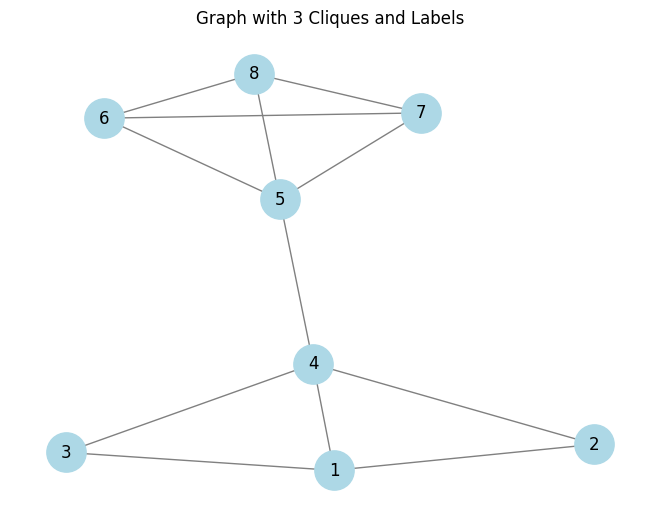

Graph: Graph with 8 nodes and 12 edges
Node labels: {0, 1}


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def create_clique_graph():
    # Create an empty graph
    G = nx.Graph()

    # Define three cliques (you can modify the size of each clique)
    clique1 = [1, 2, 3, 4]
    clique2 = [5, 6, 7, 8]
    clique3 = [9, 10, 11, 12]

    # Add the cliques to the graph
    G.add_nodes_from(clique1)
    G.add_nodes_from(clique2)
   # G.add_nodes_from(clique3)

    # Add edges to make them fully connected (complete subgraphs)
   # G.add_edges_from([(i, j) for i in clique1 for j in clique1 if i != j])
    G.add_edges_from([(i, j) for i in clique2 for j in clique2 if i != j])
  #  G.add_edges_from([(i, j) for i in clique3 for j in clique3 if i != j])
    # For example, adding edges between clique1 and clique2
    G.add_edge(1, 3)  # Bridge between clique1 and clique2
    G.add_edge(1, 4)  # Bridge between clique1 and clique2
    G.add_edge(1, 2)  # Bridge between clique1 and clique2
    G.add_edge(4, 2)  # Bridge between clique1 and clique2
    G.add_edge(4, 3)  # Bridge between clique1 and clique2

    G.add_edge(4, 5)  # Bridge between clique1 and clique2

   # G.add_edge(3, 5)  # Bridge between clique1 and clique2

    # G.add_edge(8, 9)  # Bridge between clique2 and clique3
    # G.add_edge(3, 10)  # Bridge between clique1 and clique3

    # Assign a unique label for each clique
    #labels = {0,0,0,0,1,1,1,1,2,2,2,2}
    labels = {0,0,0,0,1,1,1,1}

    # Draw the graph
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800, font_size=12)
    plt.title("Graph with 3 Cliques and Labels")
    plt.show()

    # Return the graph and the list of labels
    return G, np.array(labels)

# Call the function and print the graph and labels
graph, node_labels = create_clique_graph()
print("Graph:", graph)
print("Node labels:", node_labels)


In [ ]:
import collections
import random
import time
import networkx as nx
import matplotlib.pyplot as plt


class LPA:
    def __init__(self, G, max_iter=20):
        self._G = G
        self._n = len(G.nodes(False))  # 节点数目
        self._max_iter = max_iter

    # 判断是否收敛
    def can_stop(self):
        # 每个节点的标签和邻近节点最多的标签一样
        for i in range(self._n):
            node = self._G.nodes[i]
            label = node["label"]
            max_labels = self.get_max_neighbor_label(i)
            if label not in max_labels:
                return False
        return True

    # 获得邻近节点最多的标签
    def get_max_neighbor_label(self, node_index):
        m = collections.defaultdict(int)
        for neighbor_index in self._G.neighbors(node_index):
            neighbor_label = self._G.nodes[neighbor_index]["label"]
            m[neighbor_label] += 1
        max_v = max(m.values())
        # 可能多个标签数目相同，这里都要返回
        return [item[0] for item in m.items() if item[1] == max_v]

    # 异步更新
    def populate_label(self):
        # 随机访问
       # visitSequence = random.sample(self._G.nodes(), len(self._G.nodes()))
        visitSequence = random.sample(list(self._G.nodes()), len(self._G.nodes()))

        for i in visitSequence:
            node = self._G.nodes[i]
            label = node["label"]
            max_labels = self.get_max_neighbor_label(i)
            # 如果标签不在最大标签集中才更新，否则相同随机选取没有意义
            if label not in max_labels:
                newLabel = random.choice(max_labels)
                node["label"] = newLabel

    # 根据标签得到社区结构
    def get_communities(self):
        communities = collections.defaultdict(lambda: list())
        for node in self._G.nodes(True):
            label = node[1]["label"]
            communities[label].append(node[0])
        return communities.values()

    def execute(self):
        # 初始化标签
        for i in range(self._n):
            self._G.nodes[i]["label"] = i
        iter_time = 0
        # 更新标签
        while (not self.can_stop() and iter_time < self._max_iter):
            self.populate_label()
            iter_time += 1
        return self.get_communities()


# 可视化划分结果
def showCommunity(G, partition, pos):
    # 划分在同一个社区的用一个符号表示，不同社区之间的边用黑色粗体
    cluster = {}
    labels = {}
    for index, item in enumerate(partition):
        for nodeID in item:
            labels[nodeID] = r'$' + str(nodeID) + '$'  # 设置可视化label
            cluster[nodeID] = index  # 节点分区号

    # 可视化节点
    colors = ['r', 'g', 'b', 'y', 'm']
    shapes = ['v', 'D', 'o', '^', '<']
    for index, item in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, nodelist=item,
                               node_color=colors[index],
                               node_shape=shapes[index],
                               node_size=350,
                               alpha=1)

    # 可视化边
    edges = {len(partition): []}
    for link in G.edges():
        # cluster间的link
        if cluster[link[0]] != cluster[link[1]]:
            edges[len(partition)].append(link)
        else:
            # cluster内的link
            if cluster[link[0]] not in edges:
                edges[cluster[link[0]]] = [link]
            else:
                edges[cluster[link[0]]].append(link)

    for index, edgelist in enumerate(edges.values()):
        # cluster内
        if index < len(partition):
            nx.draw_networkx_edges(G, pos,
                                   edgelist=edgelist,
                                   width=1, alpha=0.8, edge_color=colors[index])
        else:
            # cluster间
            nx.draw_networkx_edges(G, pos,
                                   edgelist=edgelist,
                                   width=3, alpha=0.8, edge_color=colors[index])

    # 可视化label
    nx.draw_networkx_labels(G, pos, labels, font_size=12)

    plt.axis('off')
    plt.show()


def cal_Q(partition, G):  # 计算Q
    m = len(G.edges(None, False))  # 如果为真，则返回3元组（u、v、ddict）中的边缘属性dict。如果为false，则返回2元组（u，v）
    # print(G.edges(None,False))
    # print("=======6666666")
    a = []
    e = []
    for community in partition:  # 把每一个联通子图拿出来
        t = 0.0
        for node in community:  # 找出联通子图的每一个顶点
            t += len([x for x in G.neighbors(node)])  # G.neighbors(node)找node节点的邻接节点
        a.append(t / (2 * m))
    #             self.zidian[t/(2*m)]=community
    for community in partition:
        t = 0.0
        for i in range(len(community)):
            for j in range(len(community)):
                if (G.has_edge(community[i], community[j])):
                    t += 1.0
        e.append(t / (2 * m))

    q = 0.0
    for ei, ai in zip(e, a):
        q += (ei - ai ** 2)
    return q


if __name__ == '__main__':
    #G = nx.karate_club_graph()
    #pos = nx.spring_layout(G)
    exec_time=0
    for i in range(100):
      start_time = time.time()
      algorithm = LPA(G)
      communities = algorithm.execute()
      end_time = time.time()
      exec_time+=(end_time - start_time)

    # for community in communities:
    #     print(community)

    # print(cal_Q(communities, G))
    print(f'time {exec_time/100}')
    # 可视化结果
    # showCommunity(G, communities, pos)

time 0.0027827906608581545


# **Code**

In [ ]:
import networkx as nx
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict
from scipy.stats import mode
from networkx.algorithms.community import modularity
import time
import requests
import math
from collections import defaultdict
import matplotlib.pyplot as plt

def load_dataset(dataset_name):
    datasets = {
        'football': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/football.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x)
        },
        'dolphins': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/dolphins.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x) - 1
        },
        'karate': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/karate.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x) - 1
        }
    }
    if dataset_name not in datasets:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    dataset_info = datasets[dataset_name]
    url = dataset_info['url']
    label_attr = dataset_info['label_attr']
    label_transform = dataset_info['label_transform']

    local_filename = f"{dataset_name}.gml"
    response = requests.get(url)
    with open(local_filename, "wb") as f:
        f.write(response.content)

    G = nx.read_gml(local_filename, label='id')
    true_labels = np.array([label_transform(G.nodes[n][label_attr]) for n in G.nodes])
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels

import math
from collections import defaultdict
import networkx as nx

def adamic_adar_index_f(graph: nx.Graph) -> defaultdict:
    """
    Compute the Adamic-Adar index for edges in the graph.

    The Adamic-Adar index is computed only for pairs of nodes (u, v) that are directly connected by an edge.
    It considers only common neighbors z with degree(z) > 2 and stores the score only if it exceeds 1.0.

    Parameters:
    graph (nx.Graph): The input graph (undirected).

    Returns:
    defaultdict: A dictionary of dictionaries where similarities[u][v] contains the Adamic-Adar score for edge (u, v)
                 if the score > 1.0.
    """

    # Precompute neighbor sets for all nodes
    neighbor_sets = {u: set(graph.neighbors(u)) for u in graph.nodes()}

    # Precompute 1 / log(degree(z)) for all nodes with degree(z) > 2
    inv_log_degree = {}
    for z in graph.nodes():
        degree_z = len(neighbor_sets[z])  # Degree from precomputed set
        if degree_z > 2:
            inv_log_degree[z] = 1.0 / math.log(degree_z)
        else:
            inv_log_degree[z] = 0.0

    # Initialize similarities dictionary
    similarities = defaultdict(dict)

    # Compute AA index for each edge (u, v)
    for u in graph.nodes():
        neighbors_u = neighbor_sets[u]
        for v in graph.neighbors(u):
            if v not in similarities[u]:
                neighbors_v = neighbor_sets[v]
                common = neighbors_u & neighbors_v
                aa_score = sum(inv_log_degree[z] for z in common)
                if aa_score > 0.0:
                    similarities[u][v] = aa_score

    return similarities

def adamic_adar_index(graph):
    similarities = defaultdict(dict)
    for u in graph.nodes:
        neighbors_u = set(graph.neighbors(u))
        for v in graph.neighbors(u):
            if v not in similarities[u]:
                neighbors_v = set(graph.neighbors(v))
                common = neighbors_u & neighbors_v
                aa_score = 0.0
                for z in common:
                    degree_z = graph.degree(z)
                    if degree_z > 2:
                        aa_score += 1.0 / math.log(degree_z)
                if aa_score > 0.0:
                  similarities[u][v] = aa_score
    return similarities


# Revised LPA with stronger cohesion
def enhanced_lpa(graph, similarities, max_iter=20):
    labels = {n: n for n in graph.nodes}
    converged = False
    iter_count = 0
    node_scores = {node: sum(scores.values()) for node, scores in similarities.items()}

    while not converged and iter_count < max_iter:
      # Compute node-level scores (sum of Adamic-Adar scores for all edges of a node)
        # Sort nodes by descending Adamic-Adar score (and node ID for ties)
        nodes_sorted = sorted(graph.nodes, key=lambda x: (-node_scores[x], x))
        new_labels = labels.copy()
        changed = 0
        community_sizes = defaultdict(int)
        for n in graph.nodes:
            community_sizes[labels[n]] += 1

        for node in nodes_sorted:
            neighbors = list(graph.neighbors(node))
            if not neighbors:
                continue

            label_weights = defaultdict(float)
            for v in neighbors:
                l = labels[v]
                label_weights[l] += (similarities[node].get(v,0)*(community_sizes[l]))
            if label_weights:
                max_weight = max(label_weights.values())
                candidates = [l for l, w in label_weights.items() if w == max_weight]

                current_label = new_labels[node]
                if current_label not in candidates:
                    new_label= max(candidates, key=lambda x: node_scores[x])
                    new_labels[node] = new_label
                    changed += 1
                    #cent_scores = {l: max(node_scores[n] for n in graph.nodes if labels[n]==l) for l in candidates}
                    #new_label = max(cent_scores, key=cent_scores.get)

        if changed == 0:
            converged = True
        else:
            labels = new_labels
            iter_count += 1

    return np.array([labels[n] for n in graph.nodes])
def showCentrality(G,similarities):

      # Compute centrality scores: sum of each node's similarity values
    node_scores = {node: sum(scores.values()) for node, scores in similarities.items()}

    # Extract scores in the same order as G.nodes()
    scores_list = [node_scores[node] for node in G.nodes()]

    # 3. Set up node size and color based on centrality
    #    Adjust the multiplication factor to get a good size range
    node_sizes = [score * 200 for score in scores_list]
    node_colors = scores_list

    # 4. Draw the network
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # positions for consistent layout

    # Draw nodes with a colormap, so each node is colored by its centrality score
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,   # You can try other color maps like 'plasma', 'coolwarm', etc.
    )

    # Draw edges and labels
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos,font_size=10, font_color='black')

    # Add a colorbar to the plot
    cbar = plt.colorbar(nodes)
    cbar.set_label('Centrality')

    plt.title("dolphins Network Centrality")
    plt.axis('off')  # Hide the axis for a cleaner look
    plt.show()
def align_labels(y_true, y_pred):
    label_map = {}
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        mode_result = mode(y_true[mask], keepdims=True)
        true_label = np.atleast_1d(mode_result.mode)[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)
# Execution and Evaluation
G, true_labels = load_dataset('karate') #karate  or dolphins , football
# G = nx.LFR_benchmark_graph(n=5000, mu=0.1, tau1=1.2, tau2=2, average_degree=15, max_community=50, seed=42)
#true_labels = {node: G.nodes[node]["community"] for node in G.nodes()}

execution_time=0
for i in range(100):
  start_time = time.time()
  # Execute and evaluate
  similarities = adamic_adar_index(G) #adamic_adar_index(G)
  pred_labels = enhanced_lpa(G,similarities)
  execution_time += (time.time() - start_time)
# Calculate metrics
aligned_pred = align_labels( true_labels,pred_labels)
unique_labels = np.unique(pred_labels)

predicted_communities = [set(np.where(pred_labels == label)[0]) for label in unique_labels]

# Calculate metrics
nmi = normalized_mutual_info_score(true_labels, pred_labels)
ari = adjusted_rand_score(true_labels, pred_labels)
f1 = f1_score(true_labels, aligned_pred ,average='micro' )
acc = accuracy_score(true_labels, pred_labels)
# Convert the predicted labels into community sets

modularity_score = modularity(G, predicted_communities)
print(f"True communities: {len(np.unique(true_labels))}")
print(f"Predicted communities: {len(np.unique(pred_labels))}")
print(f"Predicted communities Align: {len(np.unique(aligned_pred))}")

print(f'\nModularity: {modularity_score}')
print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")
print(f"F1: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Avg Execution time: {execution_time/100} seconds")

#showCentrality(G,similarities)

True communities: 2
Predicted communities: 2
Predicted communities Align: 2

Modularity: 0.3717948717948718
NMI: 0.8372
ARI: 0.8823
F1: 0.9706
Accuracy: 0.4706
Avg Execution time: 0.0019738459587097168 seconds


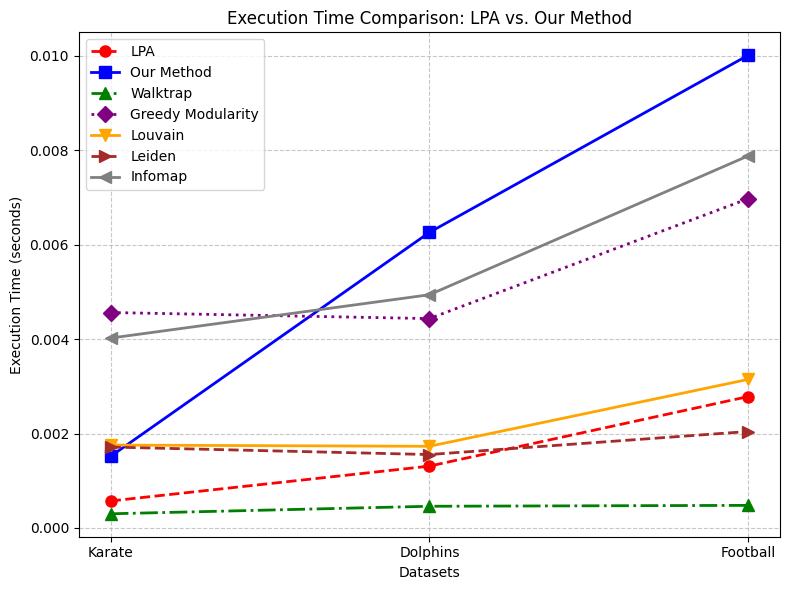

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
datasets = ['Karate', 'Dolphins', 'Football']
lpa_times = [0.0005707693099975586, 0.001309030055999756, 0.0027827906608581545]
our_times = [0.00151641845703125, 0.006261310577392578, 0.010014441013336182  ] #0.017590169906616212
Walktrap = [0.0002989339828491211, 0.0004586052894592285, 0.0004774975776672363]
GreedyModularity = [0.004563605785369873, 0.00443497896194458,0.006975150108337403]
Louvain = [0.0017552852630615234, 0.0017289185523986816,0.0031461572647094728]
Leiden =[0.0017130541801452636, 0.0015544414520263672 ,0.0020425772666931154]
Infomap= [0.004022145271301269 , 0.004940247535705567,0.007882611751556396 ] #0.006718018054962158 0.004092950820922852 0.017648861408233643


# Set up the bar positions
x = np.arange(len(datasets))  # Positions for the datasets
width = 0.35  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size as needed
# Plot LPA with red dashes
# Plot each method with a unique style
ax.plot(x, lpa_times, linestyle='--', color='red', marker='o',
        label='LPA', linewidth=2, markersize=8)
ax.plot(x, our_times, linestyle='-', color='blue', marker='s',
        label='Our Method', linewidth=2, markersize=8)
ax.plot(x, Walktrap, linestyle='-.', color='green', marker='^',
        label='Walktrap', linewidth=2, markersize=8)
ax.plot(x, GreedyModularity, linestyle=':', color='purple', marker='D',
        label='Greedy Modularity', linewidth=2, markersize=8)
ax.plot(x, Louvain, linestyle='-', color='orange', marker='v',
        label='Louvain', linewidth=2, markersize=8)
ax.plot(x, Leiden, linestyle='--', color='brown', marker='>',
        label='Leiden', linewidth=2, markersize=8)
ax.plot(x, Infomap, linestyle='-', color='gray', marker='<',
        label='Infomap', linewidth=2, markersize=8)

# Customize the plot
ax.set_xlabel('Datasets')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Execution Time Comparison: LPA vs. Our Method')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
import time
import networkx as nx

# --------------------
# Additional Libraries
# --------------------
# 1) python-igraph and leidenalg for Walktrap & Leiden
import igraph as ig
import leidenalg

# 2) infomap for Infomap
from infomap import Infomap

# 3) python-louvain for Louvain
import community.community_louvain as community_louvain

# 4) NetworkX built-in for Greedy Modularity (GM)
from networkx.algorithms.community import greedy_modularity_communities

# -------------------------------------------------
# Utility: Convert NetworkX Graph to igraph Graph
# -------------------------------------------------
def nx_to_igraph(nx_graph):
    """Convert a NetworkX graph into an igraph graph."""
    # Create empty igraph
    g = ig.Graph()
    # Add vertices (use the same numbering as in nx)
    g.add_vertices(list(nx_graph.nodes()))
    # Add edges
    edge_list = list(nx_graph.edges())
    g.add_edges(edge_list)
    return g

# -------------------------------------------------
# Define Each Algorithm as a Callable Function
# -------------------------------------------------

def run_walktrap(nx_graph):
    """
    Run Walktrap using python-igraph.
    Returns a list of communities (each community is a list of node IDs).
    """
    g = nx_to_igraph(nx_graph)
    walktrap_result = g.community_walktrap(steps=4)
    clustering = walktrap_result.as_clustering()
    return [list(comm) for comm in clustering]

def run_infomap(nx_graph):
    """
    Run Infomap using the 'infomap' library.
    Returns a list of communities (each community is a list of node IDs).
    """

    im.run()
    # Build a dictionary: module_id -> list of nodes
    communities_dict = {}
    for  node in im.nodes:
        #module_id = node.moduleId
        communities_dict.setdefault(node.module_id, []).append(node.node_id)

    return list(communities_dict.values())
def run_greedy_modularity(nx_graph):
    """
    Run Greedy Modularity (GM) using NetworkX's built-in method.
    Returns a list of communities (each is a frozenset of node IDs).
    """
    return list(greedy_modularity_communities(nx_graph))

def run_louvain(nx_graph):
    """
    Run Louvain using python-louvain (community_louvain).
    Returns a list of communities (each community is a list of node IDs).
    """
    partition = community_louvain.best_partition(nx_graph)
    # Convert {node: comm_id} to list of communities
    communities_dict = {}
    for node, comm_id in partition.items():
        communities_dict.setdefault(comm_id, []).append(node)
    return list(communities_dict.values())

def run_leiden(nx_graph):
    """
    Run Leiden using 'leidenalg' with igraph.
    Returns a list of communities (each community is a list of node IDs).
    """
    g = nx_to_igraph(nx_graph)
    partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)
    return [list(comm) for comm in partition]

# -------------------------------------------------
# Main: Compare Execution Times
# -------------------------------------------------

if __name__ == "__main__":
    # Example graph: Zachary's Karate Club from NetworkX
    G = nx.karate_club_graph()

    # List of (method_name, method_function) for easy iteration
    methods = [
        ("Walktrap", run_walktrap),
        ("GreedyModularity", run_greedy_modularity),
        ("Louvain", run_louvain),
        ("Leiden", run_leiden),
        ("Infomap", run_infomap),

    ]

    num_runs = 100  # Number of times to run each algorithm
    im = Infomap()
    # Add edges
    for u, v in G.edges():
        im.addLink(u, v)

    for method_name, method_func in methods:
        exec_time = 0.0
        for i in range(num_runs):
            start_time = time.time()
            # Execute the community detection
            communities = method_func(G)
            end_time = time.time()
            exec_time += (end_time - start_time)

        avg_time = exec_time / num_runs
        print(f"{method_name} - Average time over {num_runs} runs: {avg_time:} ")


Walktrap - Average time over 100 runs: 0.0002668619155883789 
GreedyModularity - Average time over 100 runs: 0.004032027721405029 
Louvain - Average time over 100 runs: 0.0019797539710998536 
Leiden - Average time over 100 runs: 0.0015610742568969726 
Infomap - Average time over 100 runs: 0.004022145271301269 


In [ ]:
! pip install infomap #leidenalg #igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.8/264.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for infomap: filename=infomap-2.8.0-cp311-cp311-linux_x86_64.whl size=7698805 sha256=40950320f324be9e683cfeb19c0001f2e81d46097b21651219957fc41f8b986e
  Stored in directory: /root/.cache/pip/wheels/f2/07/de/ee649642ec15485c0eaf89c9f06eb4f19a9b45e744e6808a8d
Successfully built infomap


True communities: 2
Predicted communities: 2
Predicted communities Align: 2

Modularity: 0.3717948717948718
NMI: 0.8372
ARI: 0.8823
F1: 0.9706
Accuracy: 0.4706
Avg Execution time: 0.0009363317489624024 seconds


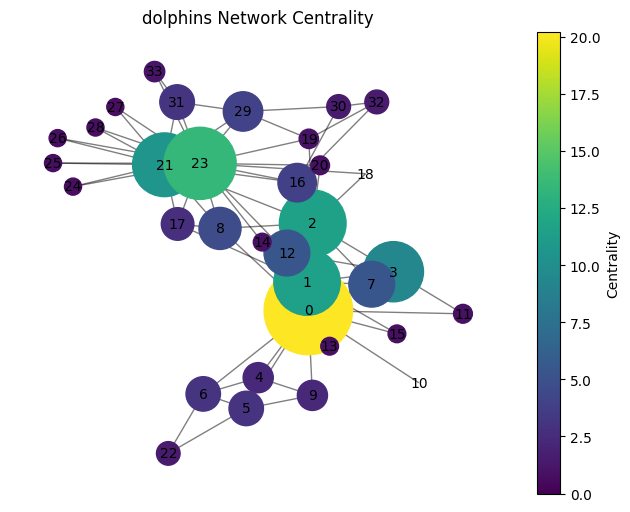

In [1]:
import networkx as nx
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score, accuracy_score
from collections import defaultdict
from scipy.stats import mode
from networkx.algorithms.community import modularity
import time
import requests
import math
from collections import defaultdict
import matplotlib.pyplot as plt

def load_dataset(dataset_name):
    datasets = {
        'football': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/football.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x)
        },
        'dolphins': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/dolphins.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x) - 1
        },
        'karate': {
            'url': "https://raw.githubusercontent.com/vlivashkin/community-graphs/master/gml_graphs/karate.gml",
            'label_attr': 'gt',
            'label_transform': lambda x: int(x) - 1
        }
    }
    if dataset_name not in datasets:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    dataset_info = datasets[dataset_name]
    url = dataset_info['url']
    label_attr = dataset_info['label_attr']
    label_transform = dataset_info['label_transform']

    local_filename = f"{dataset_name}.gml"
    response = requests.get(url)
    with open(local_filename, "wb") as f:
        f.write(response.content)

    G = nx.read_gml(local_filename, label='id')
    true_labels = np.array([label_transform(G.nodes[n][label_attr]) for n in G.nodes])
    G = nx.relabel_nodes(G, {node: int(node) for node in G.nodes})
    return G, true_labels


def adamic_adar_index(graph):
    similarities = defaultdict(dict)
    for u in graph.nodes:
        neighbors_u = set(graph.neighbors(u))
        for v in graph.neighbors(u):
            if v not in similarities[u]:
                neighbors_v = set(graph.neighbors(v))
                common = neighbors_u & neighbors_v
                aa_score = 0.0
                for z in common:
                    degree_z = graph.degree(z)
                    if degree_z > 2:
                        aa_score += 1.0 / math.log(degree_z)
                if aa_score > 0.0:
                  similarities[u][v] = aa_score
    return similarities


# AA LPA with stronger cohesion
def AA_lpa(graph, similarities, max_iter=20):
    labels = {n: n for n in graph.nodes}
    converged = False
    iter_count = 0
    node_scores = {node: sum(scores.values()) for node, scores in similarities.items()}

    while not converged and iter_count < max_iter:

        nodes_sorted = sorted(graph.nodes, key=lambda x: (-node_scores[x], x))
        new_labels = labels.copy()
        changed = 0
        community_sizes = defaultdict(int)
        for n in graph.nodes:
            community_sizes[labels[n]] += 1

        for node in nodes_sorted:
            neighbors = list(graph.neighbors(node))
            if not neighbors:
                continue

            label_weights = defaultdict(float)
            for v in neighbors:
                l = labels[v]
                label_weights[l] += (similarities[node].get(v,0)*(community_sizes[l]))
            if label_weights:
                max_weight = max(label_weights.values())
                candidates = [l for l, w in label_weights.items() if w == max_weight]

                current_label = new_labels[node]
                if current_label not in candidates:
                    new_label= max(candidates, key=lambda x: node_scores[x])
                    new_labels[node] = new_label
                    changed += 1
                    #cent_scores = {l: max(node_scores[n] for n in graph.nodes if labels[n]==l) for l in candidates}
                    #new_label = max(cent_scores, key=cent_scores.get)

        if changed == 0:
            converged = True
        else:
            labels = new_labels
            iter_count += 1

    return np.array([labels[n] for n in graph.nodes])
def showCentrality(G,similarities):

      # Compute centrality scores: sum of each node's similarity values
    node_scores = {node: sum(scores.values()) for node, scores in similarities.items()}

    # Extract scores in the same order as G.nodes()
    scores_list = [node_scores[node] for node in G.nodes()]

    # 3. Set up node size and color based on centrality
    #    Adjust the multiplication factor to get a good size range
    node_sizes = [score * 200 for score in scores_list]
    node_colors = scores_list

    # 4. Draw the network
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # positions for consistent layout

    # Draw nodes with a colormap, so each node is colored by its centrality score
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,   # You can try other color maps like 'plasma', 'coolwarm', etc.
    )

    # Draw edges and labels
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos,font_size=10, font_color='black')

    # Add a colorbar to the plot
    cbar = plt.colorbar(nodes)
    cbar.set_label('Centrality')

    plt.title("dolphins Network Centrality")
    plt.axis('off')  # Hide the axis for a cleaner look
    plt.show()
def align_labels(y_true, y_pred):
    label_map = {}
    for cluster in np.unique(y_pred):
        mask = (y_pred == cluster)
        mode_result = mode(y_true[mask], keepdims=True)
        true_label = np.atleast_1d(mode_result.mode)[0]
        label_map[cluster] = true_label
    return np.vectorize(label_map.get)(y_pred)
# Execution and Evaluation
G, true_labels = load_dataset('karate') #karate  or dolphins , football


execution_time=0
for i in range(100):
  start_time = time.time()
  # Execute and evaluate
  similarities = adamic_adar_index(G)
  pred_labels = AA_lpa(G,similarities)
  execution_time += (time.time() - start_time)
# Calculate metrics
aligned_pred = align_labels( true_labels,pred_labels)
unique_labels = np.unique(pred_labels)

predicted_communities = [set(np.where(pred_labels == label)[0]) for label in unique_labels]

# Calculate metrics
nmi = normalized_mutual_info_score(true_labels, pred_labels)
ari = adjusted_rand_score(true_labels, pred_labels)
f1 = f1_score(true_labels, aligned_pred ,average='micro' )
acc = accuracy_score(true_labels, pred_labels)
# Convert the predicted labels into community sets

modularity_score = modularity(G, predicted_communities)
print(f"True communities: {len(np.unique(true_labels))}")
print(f"Predicted communities: {len(np.unique(pred_labels))}")
print(f"Predicted communities Align: {len(np.unique(aligned_pred))}")

print(f'\nModularity: {modularity_score}')
print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")
print(f"F1: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Avg Execution time: {execution_time/100} seconds")

showCentrality(G,similarities)